# Implementation

Author: Eduardo Miguel Firvida Donestevez

In this tutorial, you will learn how to:

- Static deformation of IEA 15MW Offshore Reference Turbine


In [ ]:
import os
from pathlib import Path

CURRENT_FOLDER = Path().resolve()
DATA_FOLDER = os.path.join(CURRENT_FOLDER, "data")
OUTPUT_FOLDER = os.path.join(CURRENT_FOLDER, "output")


## Read pyNumad blade definition

The blade definition was taken from the PyNumad Original github repositories examples
here: https://github.com/sandialabs/pyNuMAD/blob/main/examples/example_data/IEA-15-240-RWT.yaml


In [ ]:
bladeYaml = os.path.join(DATA_FOLDER, "IEA-15-240-RWT.yaml")


Create mesh object, and mesh solid FEM blade


In [ ]:
from turbine_mesher.mesh import Mesh

blade = Mesh(bladeYaml, element_size=0.2)

In [ ]:
blade.shell_mesh()


In [50]:
import meshio
import gmsh

TEMP_MESH = "malla_output_v2.msh"
meshio.write(TEMP_MESH, blade.mesh, file_format="gmsh22",binary=False)


# Inicializar la API de GMSH
gmsh.initialize()
gmsh.option.setNumber("General.Terminal", 1)
gmsh.merge(TEMP_MESH)

# gmsh.model.mesh.reclassifyNodes()
# print("Reclasificación completada.")

# gmsh.model.mesh.generate(1)
# gmsh.model.mesh.generate(2)
# print("Conversión a segundo orden completada.")

gmsh.model.mesh.setOrder(2)
# print("Conversión a segundo orden completada.")

entities = gmsh.model.getEntities(dim=2)  # Dimensión 2 para superficies
print("Superficies disponibles:", entities)
# Seleccionar la superficie deseada (por ejemplo, la de tag 1)
surface_tag = 0  # Cambia esto al identificador de la superficie que deseas agrupar

# Crear el grupo físico para esta superficie
physical_group_name = "MySurface"
physical_group_dimension = 2  # Dimensión 2 para superficies
physical_group_tag = gmsh.model.addPhysicalGroup(physical_group_dimension, [surface_tag], tag=999)
gmsh.model.setPhysicalName(physical_group_dimension, physical_group_tag, physical_group_name)
print(f"Grupo físico '{physical_group_name}' creado para la superficie con tag {surface_tag}.")


gmsh.write(TEMP_MESH)


Warning: Appending zeros to replace the missing physical tag data.

Warning: Appending zeros to replace the missing geometrical tag data.

Info    : Reading 'malla_output_v2.msh'...
Info    : 37253 nodes
Info    : 76388 elements
Info    : Done reading 'malla_output_v2.msh'
Info    : Meshing order 2 (curvilinear on)...
Info    : Meshing surface 0 order 2
Info    : Surface mesh: worst distortion = 1 (0 elements in ]0, 0.2]); worst gamma = 0.0047897
Info    : Done meshing order 2 (Wall 0.205562s, CPU 0.199801s)
Superficies disponibles: [(2, 0)]
Grupo físico 'MySurface' creado para la superficie con tag 0.
Info    : Writing 'malla_output_v2.msh'...
Info    : Done writing 'malla_output_v2.msh'


### View mesh with PyVista

To plot the mesh we need to transform the MeshioMesh to pyVista.


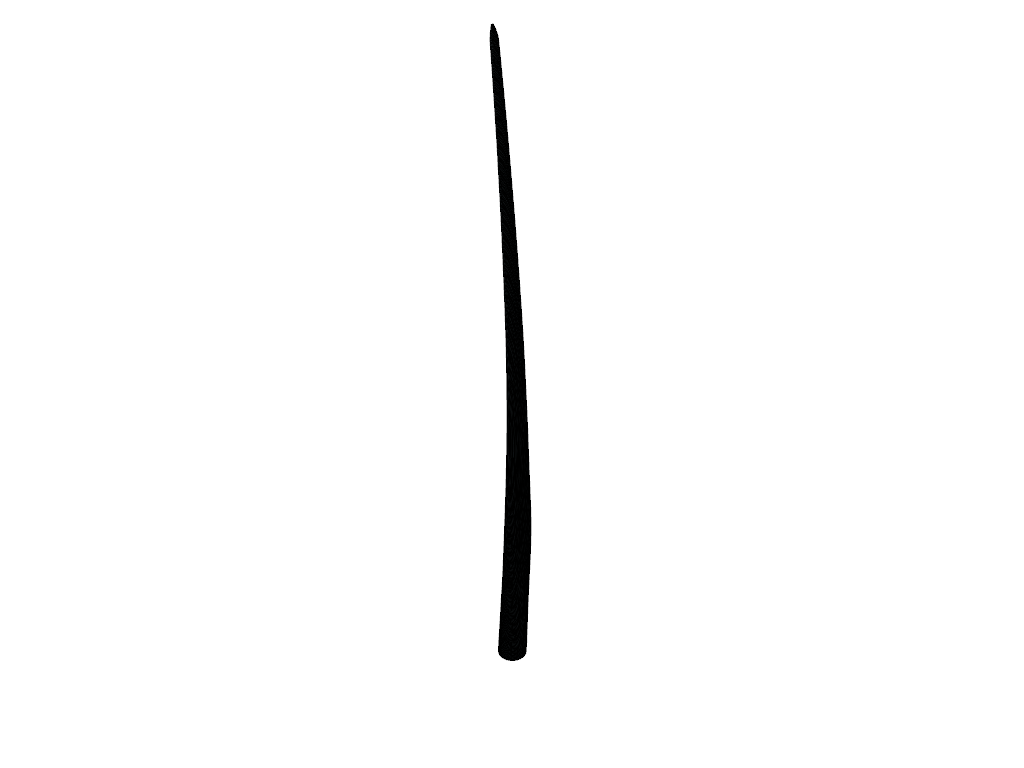

In [51]:
import numpy as np
import pyvista as pv
pv.set_jupyter_backend('static')  

from pyvista import CellType


def meshio_to_pyvista(mesh):
    points = mesh.points
    cells = []
    cell_type = np.array(
        [CellType.TRIANGLE for i in range(sum(len(i.data) for i in mesh.cells))], np.int32
    )

    for cell_block in mesh.cells_dict.values():
        for cell in cell_block:
            cells.extend([3] + cell.tolist())

    cells = np.array(cells)
    grid = pv.UnstructuredGrid(cells, cell_type, points)
    return grid

pv_mesh = meshio_to_pyvista(blade.mesh)
plotter = pv.Plotter()
plotter.add_mesh(pv_mesh, show_edges=True)
plotter.show()


Prepare mesh for DOLFINx


In [52]:
from mpi4py import MPI
import numpy as np

import dolfinx
import ufl
from basix.ufl import element, mixed_element
from dolfinx import plot, fem
from dolfinx.fem import Function, dirichletbc, functionspace
from dolfinx.fem.petsc import LinearProblem
from dolfinx.io.utils import XDMFFile
from dolfinx.mesh import CellType, create_unit_square
from ufl import dx, grad, inner, split, sym, tr
import pyvista
import basix


In [53]:

domain, markers, facets = dolfinx.io.gmshio.read_from_msh(TEMP_MESH, MPI.COMM_WORLD)

gdim = domain.geometry.dim
tdim = domain.topology.dim

print(f"Geometrical dimension = {gdim}")
print(f"Topological dimension = {tdim}")

Info    : Reading 'malla_output_v2.msh'...
Info    : 1 entity
Info    : 150896 nodes
Info    : 76388 elements                                                                                      
Info    : Done reading 'malla_output_v2.msh'
Geometrical dimension = 3
Topological dimension = 2


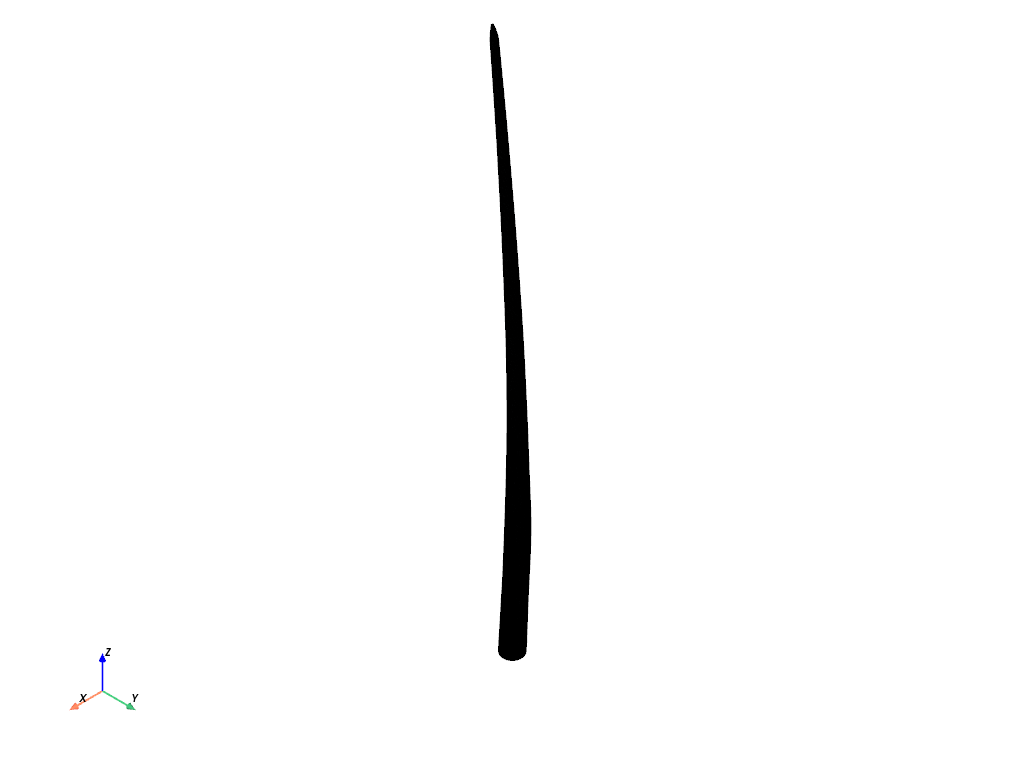

In [54]:

pyvista.set_jupyter_backend("static")
plotter = pyvista.Plotter()
ugrid = pyvista.UnstructuredGrid(*plot.vtk_mesh(domain))
plotter.add_mesh(ugrid, show_edges=True)
plotter.show_axes()
plotter.show()

In [55]:
# material parameters
thick = fem.Constant(domain, 1.0)
E = fem.Constant(domain, 210e9)
nu = fem.Constant(domain, 0.3)
lmbda = E * nu / (1 + nu) / (1 - 2 * nu)
mu = E / 2 / (1 + nu)
lmbda_ps = 2 * lmbda * mu / (lmbda + 2 * mu)

# loading (self-weight + transverse component)
f = fem.Constant(domain, (0, 0.2, -1))

In [56]:
def normalize(v):
    """Normalize a vector to unit norm."""
    return v / ufl.sqrt(ufl.dot(v, v))


def local_frame(mesh):
    t = ufl.Jacobian(mesh)
    if mesh.geometry.dim == 2:
        t1 = ufl.as_vector([t[0, 0], t[1, 0], 0])
        t2 = ufl.as_vector([t[0, 1], t[1, 1], 0])
    else:
        t1 = ufl.as_vector([t[0, 0], t[1, 0], t[2, 0]])
        t2 = ufl.as_vector([t[0, 1], t[1, 1], t[2, 1]])
    e3 = normalize(ufl.cross(t1, t2))
    ey = ufl.as_vector([0, 1, 0])
    ez = ufl.as_vector([0, 0, 1])
    e1 = ufl.cross(ey, e3)
    norm_e1 = ufl.sqrt(ufl.dot(e1, e1))
    e1 = ufl.conditional(ufl.lt(norm_e1, 0.5), ez, normalize(e1))

    e2 = normalize(ufl.cross(e3, e1))
    return e1, e2, e3


VT = fem.functionspace(domain, ("DG", 0, (gdim,)))
V0, _ = VT.sub(0).collapse()

frame = local_frame(domain)
basis_vectors = [fem.Function(VT, name=f"Basis_vector_e{i+1}") for i in range(gdim)]
e1, e2, e3 = basis_vectors


for i in range(gdim):
    e_exp = fem.Expression(frame[i], V0.element.interpolation_points())
    basis_vectors[i].interpolate(e_exp)


results_folder = Path("results")
results_folder.mkdir(exist_ok=True, parents=True)
with dolfinx.io.VTKFile(MPI.COMM_WORLD, results_folder / "local_frame.pvd", "w") as vtk:
    vtk.write_function(e1, 0.0)
    vtk.write_function(e2, 0.0)
    vtk.write_function(e3, 0.0)

In [ ]:
Ue = basix.ufl.element("P", domain.basix_cell(), 2, shape=(gdim,))  # displacement finite element
Te = basix.ufl.element("CR", domain.basix_cell(), 1, shape=(gdim,)) # rotation finite element
V = fem.functionspace(domain, basix.ufl.mixed_element([Ue, Te]))

v = fem.Function(V)
u, theta = ufl.split(v)

v_ = ufl.TestFunction(V)
u_, theta_ = ufl.split(v_)
dv = ufl.TrialFunction(V)

CellType.triangle


In [58]:
def vstack(vectors):
    """Stack a list of vectors vertically."""
    return ufl.as_matrix([[v[i] for i in range(len(v))] for v in vectors])


def hstack(vectors):
    """Stack a list of vectors horizontally."""
    return vstack(vectors).T


# In-plane projection
P_plane = hstack([e1, e2])


def t_grad(u):
    """Tangential gradient operator"""
    g = ufl.grad(u)
    return ufl.dot(g, P_plane)

In [59]:
t_gu = ufl.dot(P_plane.T, t_grad(u))
eps = ufl.sym(t_gu)
beta = ufl.cross(e3, theta)
kappa = ufl.sym(ufl.dot(P_plane.T, t_grad(beta)))
gamma = t_grad(ufl.dot(u, e3)) - ufl.dot(P_plane.T, beta)

eps_ = ufl.derivative(eps, v, v_)
kappa_ = ufl.derivative(kappa, v, v_)
gamma_ = ufl.derivative(gamma, v, v_)

In [60]:
def plane_stress_elasticity(e):
    return lmbda_ps * ufl.tr(e) * ufl.Identity(tdim) + 2 * mu * e


N = thick * plane_stress_elasticity(eps)
M = thick**3 / 12 * plane_stress_elasticity(kappa)
Q = mu * thick * gamma

In [61]:
drilling_strain = (t_gu[0, 1] - t_gu[1, 0]) / 2 + ufl.dot(theta, e3)
drilling_strain_ = ufl.replace(drilling_strain, {v: v_})

h_mesh = ufl.CellDiameter(domain)
drilling_stiffness = E * thick**3 / h_mesh**2
drilling_stress = drilling_stiffness * drilling_strain

In [62]:
Vu,Vu_map = V.sub(0).collapse()
dofs = [i for i,c in enumerate(Vu.tabulate_dof_coordinates()) if np.abs(c[2])<=1e-8]
print(len(dofs))
uD = fem.Function(Vu)
bcs = [fem.dirichletbc(uD, dofs, V.sub(0))]


164


TypeError: __init__(): incompatible function arguments. The following argument types are supported:
    1. __init__(self, g: ndarray[dtype=float64, order='C', writable=False], dofs: ndarray[dtype=int32, shape=(*), order='C', writable=False], V: dolfinx.cpp.fem.FunctionSpace_float64) -> None
    2. __init__(self, g: dolfinx.cpp.fem.Constant_float64, dofs: ndarray[dtype=int32, shape=(*), order='C', writable=False], V: dolfinx.cpp.fem.FunctionSpace_float64) -> None
    3. __init__(self, g: dolfinx.cpp.fem.Function_float64, dofs: ndarray[dtype=int32, shape=(*), order='C', writable=False]) -> None
    4. __init__(self, g: dolfinx.cpp.fem.Function_float64, dofs: collections.abc.Sequence[ndarray[dtype=int32, shape=(*), order='C', writable=False]], V: dolfinx.cpp.fem.FunctionSpace_float64) -> None

Invoked with types: dolfinx.cpp.fem.DirichletBC_float64, dolfinx.cpp.fem.Function_float64, list, dolfinx.cpp.fem.FunctionSpace_float64

In [ ]:
Wdef = (
    ufl.inner(N, eps_ )
    + ufl.inner(M, kappa_)
    + ufl.dot(Q, gamma_)
    + drilling_stress * drilling_strain_
) * ufl.dx
a = ufl.derivative(Wdef, v, dv)
Wext = ufl.dot(f, u_) * ufl.dx

problem = dolfinx.fem.petsc.LinearProblem(
    a, Wext, u=v, bcs=bcs, petsc_options={"ksp_type": "preonly", "pc_type": "lu"}
)
problem.solve()

In [ ]:
u_out = v.sub(0).collapse()
u_out.name = "Displacement"
theta_out = v.sub(1).collapse( )
theta_out.name = "Rotation"

with io.VTKFile(MPI.COMM_WORLD, results_folder / "displacement.pvd", "w") as vtk:
    vtk.write_function(u_out, 0.0)
with io.VTKFile(MPI.COMM_WORLD, results_folder / "rotation.pvd", "w") as vtk:
    vtk.write_function(theta_out, 0.0)